# BSOC as a Convoultional Layer

This work is based on papers by Dr. Gabriel Ferrer from Hendrix College. I will explore the practicality of using Bounded Self-Organizing Clusters (BSOC) as a way to create the first convoultional in a convoultional network. I will be using Pytorch as a baseline in this notebook.

## Data:
The data comes from pictures taken on a Galaxy S8 at 1280x720px.
### 7/9/2018
Room: 10 Pictures <br/>
Kitchen: 10 Pictures

## 1: Running a basic test with CIFAR10:

In [1]:
## Loading the Data
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Files already downloaded and verified
Files already downloaded and verified
truck  bird  bird   car


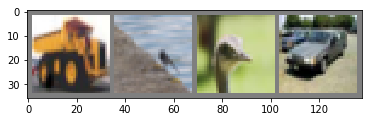

In [2]:
imshow(torchvision.utils.make_grid(images))


In [32]:
np.zeros((2,3,4)) ## creates 2, 3x4 arrays
import heapq as hq

## Let's write a wrapper around heapq to help keep us sane.
## this heap needs to let us remove an arbitrary amount of edges hopefully


class Heap():
    def __init__(self):
        self.list = []
    def add(self, item, priority=0):
        hq.heappush(self.list, (priority, item))
    def add_many(self, entries_list, entries_priorities):
        self.list += [li for li in zip(entries_priorities, entries)]
        hq.heapify(self.list)
    def pop(self):
        return hq.heappop(self.list)
    def filter_f(self, filter_func):
        self.list = list(filter(filter_func, self.list))
        hq.heapify(self.list)
    def remove_many(self, entries):
        set_check = set(entries)
        self.list = [(p,e) for p,e in self.list if e not in set_check]
        hq.heapify(self.list)
        ## we do this because it is faster to create a new list rather than modify a ton of items in a list
        ## Todo, check if this is faster than a for loop to remove each item from a list.
    def __remove_1(self, entry):
        i_to_remove = -1;
        for i in range(len(self.list)):
            p,e = self.list[i]
            if e == entry:
                i_to_remove = i
        if i_to_remove == -1:
            raise ValueError("Could not find entry in heap")
        del self.list[i_to_remove]
        
    def remove(self, entry):
        self.__remove_1(entry)
        hq.heapify(self.list)
    def remove_many_inplace(self, entries):
        for e in entries:
            self.__remove_1(e)
        
    
        
## Let's also just name our edges for sanity sake
class Edge():
    def __init__(self, a, b, weight):
        self.a = a
        self.b = b
        self.weight = weight
    def __eq__(self, other):
        return other.contains(self.a) and other.contains(self.b) and other.weight == self.weight

    ## checks if a or b is c
    def contains(self, c):
        return self.a == c or self.b == c
        
        

In [33]:
h = Heap()
h.add('')
h.add('second item')
h.add('3rd item')
print(h.list)
# h.remove_many(["first item", "3rd item"])
h.filter_f(lambda x: x[1] == "3rd item")
print(h.list)

np.array([1,2,3]) == np.array([1,2,3])

[(0, ''), (0, 'second item'), (0, '3rd item')]
[(0, '3rd item')]


array([ True,  True,  True])

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import queue

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.fc1 = nn.Linear(10 * 28 * 28, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10 * 28 * 28)
        x = self.fc1(x)
        return x

class BSOC_Image_Node():
    def __init__(self, node_height, node_width, node_channels, ID = -1,  merge_count = 1, array=None, =None):
        self.height = node_height
        self.width = node_width
        self.channels = node_channels
        self.ID = ID
        
        if array == None:  
            self.array = np.zeroes(shape=(node_height, node_width, node_channels))
        else :
            self.array = array
        self.merge_count = merge_count
    
    ## Returns a new node of this node and the other node merged together
    ## merge_f(node1, node2) returns NParray and merge_count or new node. 
    def merge(self, other_node, merge_func = None):
        if merge_func == None:
            ## default merge
            newCount = node1.merge_count + node2.merge_count
            a1 = node1.array
            a2 = node2.array
            a3 = (a1 + a2) / 2
            return BSOC_Image_Node(self.height, self.width, self.channels, a3, newCount)
        return merge_func(self, other_node)
    
    def __eq__(self, other):
        return other.ID == self.ID
#         return np.array_equal(self.array, other.array) and self.merge_count == other.merge_count
        
    def calculate_distance(self, other):
        return self.merge_count * np.sum(np.absolute(self.array - other.array))
        
        
        
class BSOC():
    ## Creates  
    def __init__(self, nodes, node_height, node_width, node_channels=1):
        self.total_nodes = nodes
        self.node_rows = node_height
        self.node_columns = node_width
        self.node_channels = node_channels
        self.node_list = []
        self.pq = Heap()
        self.generator = self.__default_generator()
        
    def __default_generator(self):
        i = 0
        while True:
            yield i
            i += 1
    def next_ID(self):
        return next(self.generator)
    ## if we're below the node threshold, then place the pixel array into the numpy list, 
    def add_node(self, pixel_arr):
        if len(self.node_list) < self.total_nodes:
            node = BSOC_Image_Node(self.node_height, self.node_width, self.node_channels)
            ## Add the node to the priority queue. 
            self.add_node_and_edges(node)
            
        else:
            e = self.pq.pop()   
            self.node_list = [x if x not in [e.a, e.b]] ## deletes a and b from the list
            self.pq.filter_f(lambda x: x[1].contains(e.a) or x[1].contains(e.b)) ## filters out a and b
            
            
            
    def add_node_and_edges(self, node):
        for n in self.node_list:
                e = Edge(node, n, priority=n.calculate_distance(node))
                self.pq.add(e, e.priority)
        self.node_list.add(node)

    ## merges nodes a and b and adds their respective edges to the priority queue
    ## merge_func = function to merge together the nodes at the indeces
    def __merge(self, a, b, merge_func=None):
        new_node = a.merge(b, merge_func)
        add_node_and_edges(new_node)
        
        
        
        
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         print(x.size())
#         x = self.pool(F.relu(self.conv1(x)))
#         print(x.size())
#         x = self.pool(F.relu(self.conv2(x)))
#         print(x.size())
#         x = x.view(-1, 16 * 5 * 5)
#         print(x.size())
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x



# class BSOCNet(nn.Module):
#     def __init__(self):
#         super(BSOCNet, self).__init__()
        
net = ConvNet()

It looks like from [here](https://discuss.pytorch.org/t/defining-a-conv2d-layer-with-fixed-kernel/8684) that we can use F.conv2d to manually define layers [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d) and [this](https://discuss.pytorch.org/t/pytorch-replace-torch-nn-conv2d-with-torch-nn-functional-conv2d/16596) link might help if we get errors

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.038
[1,  4000] loss: 2.010
[1,  6000] loss: 2.026
[1,  8000] loss: 2.018
[1, 10000] loss: 2.019
[1, 12000] loss: 2.035
[2,  2000] loss: 1.989
[2,  4000] loss: 1.982
[2,  6000] loss: 2.024
[2,  8000] loss: 2.018
[2, 10000] loss: 2.011
[2, 12000] loss: 2.020
Finished Training


Evidently, using only a Convoluted layer and a MLP/Dense layer is not a good classifier. The commented out code above is the tuorial which gives much lower loss (around 1.12)

(10, 3, 5, 5)
(3,)
[[-0.09637843  0.08512098  0.11013851 -0.01549788  0.02775969]
 [ 0.06870964  0.05168772 -0.03357208 -0.06287108  0.02407114]
 [-0.0111529  -0.08104364  0.03487998 -0.10813116  0.00409912]
 [ 0.01432148  0.07148701  0.06743662 -0.0345263   0.05942763]
 [ 0.08592044  0.0579102  -0.0812898   0.05857071  0.0347359 ]]
0
[[ 0.10365884 -0.00947934  0.05508061  0.09593777  0.11002512]
 [ 0.02702767  0.11001402  0.07536751  0.06760682 -0.02529428]
 [-0.01035385 -0.02507612  0.04104014 -0.05594692 -0.03454244]
 [ 0.10841495 -0.07611939  0.07138833  0.02999318  0.04930627]
 [ 0.0108217   0.02096641  0.10466358  0.0571364  -0.09553624]]
10
[[ 0.10512796 -0.03005054 -0.00940652  0.08912785 -0.03248838]
 [ 0.0964251   0.11412682 -0.02998253  0.02109608 -0.06853302]
 [-0.06128663  0.01218118  0.10603376  0.01264136  0.06043579]
 [-0.07368945 -0.0846523  -0.02348094  0.02945076 -0.02664285]
 [-0.00015405 -0.02702193 -0.08856401  0.10429175  0.10138449]]
20


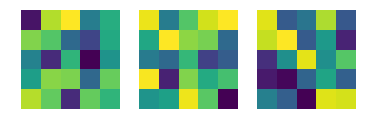

In [34]:
def view_kernels(tensor):
    width, height, kern_width, kern_height = tensor.shape
    _, axarr = plt.subplots(1 , height)
    print(axarr.shape)
    h = 0
    w = 0
    while ((h * height + w * width) < (height * width)):
        axarr[w].axis('off')
        axarr[w].imshow(tensor[w][h])
        print(tensor[w][h])
        print((h * height + w * width))
        w += 1
        if w >= width:
            h += 1
            w = 0
    
    
count = 0
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        if count == 0:
            print((m.weight.data.numpy().shape))
            view_kernels(m.weight.data.numpy())
        count += 1

How do people define convolutional layers initially besides random. 
ConvNet with fixed kernels and without (no back propagation) 
ConvNet without fixed kernels (Normal)
BSOCNet with Fixed kernels (Hypothesis)
BSOCNet with without fixed kternels. 
how are the convolutional network weights back propagated?